<a href="https://colab.research.google.com/github/yangangchen/TextMining/blob/master/TextMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords, names, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.util import ngrams


random.seed(0)
np.random.seed(1)
np.set_printoptions(precision=6, threshold=np.inf, linewidth=np.inf, suppress=True)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', -1)
pretty_print = lambda df: display(HTML(df.to_frame().to_html())) if "Series" in df.__class__.__name__ else display(
    HTML(df.to_html()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Step 1: obtaining the data**

**Step 2: exploration**

Example from

https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

https://archive.ics.uci.edu/ml/machine-learning-databases/00462/

In [2]:
df_train = pd.read_table('data/drugsComTrain_raw.tsv', index_col="Unnamed: 0").iloc[::5][[
    "drugName", "condition", "review", "rating"]]
df_test = pd.read_table('data/drugsComTest_raw.tsv', index_col="Unnamed: 0").iloc[::5][[
    "drugName", "condition", "review", "rating"]]

df_train = df_train.sort_values(by="rating")
print("Best rating: ")
pretty_print(df_train.head(5))
print("Worst rating: ")
pretty_print(df_train.tail(5))

Best rating: 


,drugName,condition,review,rating
222862,Topamax,Migraine Prevention,"""I took Topamax for 2 months until I finally threw in the towel and could take no more. It did stop the migraines but the other side effects were horrible. I did have the tingling in my hands, feet, and lips and food did taste way different. I was so depressed I could barely even get out of the bed. I actually GAINED about 5 lbs. while I notice most everyone else lost weight. I cried everyday for a week straight and I&#039;m not like that. My house was a wreck and I could barely help my son with his homework. """,1.0
213614,Tioconazole,Vaginal Yeast Infection,"""I WISH I WOULD&#039;VE READ THESE BEFORE! I&#039;ve used the 1 day treatment before and had great results, but not this time. I want to straddle a cactus. I had the worst burning last night and still raw and itchy this morning... it&#039;s honestly worse than before I did the medicine. I will never purchase this again. lesson learned.""",1.0
159530,Pegfilgrastim,Neutropenia Associated with Chemotherapy,"""I was the rare case that was allergic to Neulasta and ended up in the ER with anaphylaxis the day after getting the injection. After an epi-pen, many steroids, and a night in the hospital, I&#039;m still feeling the effects of the reaction a week later. I will now have to finish AC chemo without a white blood cell booster. Please be careful on this medication and call your doctor at any signs of swelling or trouble breathing.""",1.0
144173,Etonogestrel,Birth Control,"""I got the Nexplanon in December 2015 and Im getting it removed July 2016 I&#039;m 19 I&#039;ve gained 30 lbs in the past 6 months with my diet improving and more expertise it&#039;s impossible to lose hopefully getting rid of it will help. I&#039;ve also started getting really bad acne ( normally I don&#039;t have any) it&#039;s done it&#039;s job but I don&#039;t recommend it. In this case the birth control came at a cost.""",1.0
19226,Pregabalin,ibromyalgia,"""I was just diagnosed with fibromyalgia. After taking the first dose my hands and feet swelled up and I couldn&#039;t bend my figures. If I tried the pain was intense. Then I stated to stagger. I wobbled when I tried to stand still. My mind fogged up. I felt drunk and hungry. I got a sandwich and it slipped off of my plate to the floor and I picked up and continued to eat, at least a couple of times. Every thing I ate that night tasted so good. I was so sleepy. When I got up in the morning there were things in places that should never of been. (ie: TV remote in the bathroom, food on the floor near my bed and other things misplaced. I felt like I had a hangover. NEVER AGAIN. I had the same experience with Gabapentin. Just say no!""",1.0


Worst rating: 


,drugName,condition,review,rating
54078,Ritalin,ADHD,"""I was 31 years old before I began taking Ritalin. I take a small dose, 10mg in the morning and 10mg early afternoon. I wish I had been prescribed this medicine years ago. I drive a truck for a living but I also do a lot of self study (audio and printed books) and Ritalin has greatly increased my productivity with the latter and safety with the former. I experience VERY few side effects. My mind used to wander quite often, I just thought I had an active imagination, but it was a problem. I have not lost my ability to imagine or abstract yet I have lost of tendency to wander aimlessly into unrelated thought. I have also lost my ability to get lost so often while driving!""",10.0
153461,Doxycycline,Urinary Tract Infection,"""I have a severe urinary tract infection, which has also affected my left kidney. Although this medicine makes me sick every time I take it, its in my system long enough to keep in there. It is the worst medicine to ever have to take, but I have to say it is probably doing its job! I still have 4 days of it left, wish me luck, but I would recommend this to anyone who has a serious infection. I have been on 3 other medicines before this one, ciprofloxacin included, and none of them even touched it! It&#039;s worth the sickness sometimes for a healthier life!""",10.0
1030,Metronidazole,Bacterial Vaginitis,"""I haven&#039;t taken any antibiotics for 6 years, 2 days with metronidazole, I felt it right away, that it was working so well. The fact that I don&#039;t take any medication made it super helpful. Also eating the right food and taking probiotic, prebiotics daily. I know it probably doesn&#039;t make sense, taking probiotics while on antibiotics. I did some research, it&#039;s okay if you take the probiotics 2 hour or more after you take the antibiotic. They gave me metronidazole for 2x a day in 7 days. So what i did is I take it morning and night time and in between, I take probiotics and enzymes. I Also eat lots of fermented food like kimchi, lots of veggies, drinking bone broth and green juice. Green tea is also good while on antibiotics.""",10.0
83291,Paxil,Depression,"""I started to take Paxil 12years ago. I was getting depressed because of my panic disorder. I have been on Xanax for many many years and my doctor added Paxil. 30mg a day in the morning. I have never had a side effect not even weight gain and I know this can cause weight gain. It works great for me for my depression and my panic attacks. Would highly recommend this drug. I am a skinny person anyway, because of my panic but I never had any side effects. Good luck all.""",10.0
47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years, I spent my first 38 on Synthroid and various t4 formulas, I could not stand the up and down of Synthroid, it never was steady. Every time I went to the Dr. It was adjusted, it could not regulate me and most Dr&#039;s. Just played with raising and lowering the mg levels. \r\nFinally a person I new told me I should see her Dr. I did, and that was the beginning of a beautiful relationship with Armour Thyroid. I&#039;ve never felt better, my bad symptoms went away, and I feel almost human. It holds me steady for longer periods. sometimes the patient knows best, regardless of what the blood tests say. Armour contains unknown ingredients that can&#039;t be isolated into a synthetic pill form, Armour is natural, and best.""",10.0


**Step 3: text cleaning (99%)**

In [3]:
def text_cleaning(df):
    df.review = df.review.str.strip("\"").str.replace("&#039;", "\'").str.replace("It's", "It is").str.replace("it's", "it is").\
str.replace("paxil", "Paxil").str.replace("It's", "It is").str.replace("I'm", "I am")
    return df

df_train = text_cleaning(df_train)
df_test = text_cleaning(df_test)

print("Best rating: ")
pretty_print(df_train.head(5))
print("Worst rating: ")
pretty_print(df_train.tail(5))

Best rating: 


,drugName,condition,review,rating
222862,Topamax,Migraine Prevention,"I took Topamax for 2 months until I finally threw in the towel and could take no more. It did stop the migraines but the other side effects were horrible. I did have the tingling in my hands, feet, and lips and food did taste way different. I was so depressed I could barely even get out of the bed. I actually GAINED about 5 lbs. while I notice most everyone else lost weight. I cried everyday for a week straight and I am not like that. My house was a wreck and I could barely help my son with his homework.",1.0
213614,Tioconazole,Vaginal Yeast Infection,"I WISH I WOULD'VE READ THESE BEFORE! I've used the 1 day treatment before and had great results, but not this time. I want to straddle a cactus. I had the worst burning last night and still raw and itchy this morning... it is honestly worse than before I did the medicine. I will never purchase this again. lesson learned.",1.0
159530,Pegfilgrastim,Neutropenia Associated with Chemotherapy,"I was the rare case that was allergic to Neulasta and ended up in the ER with anaphylaxis the day after getting the injection. After an epi-pen, many steroids, and a night in the hospital, I am still feeling the effects of the reaction a week later. I will now have to finish AC chemo without a white blood cell booster. Please be careful on this medication and call your doctor at any signs of swelling or trouble breathing.",1.0
144173,Etonogestrel,Birth Control,I got the Nexplanon in December 2015 and Im getting it removed July 2016 I am 19 I've gained 30 lbs in the past 6 months with my diet improving and more expertise it is impossible to lose hopefully getting rid of it will help. I've also started getting really bad acne ( normally I don't have any) it is done it is job but I don't recommend it. In this case the birth control came at a cost.,1.0
19226,Pregabalin,ibromyalgia,"I was just diagnosed with fibromyalgia. After taking the first dose my hands and feet swelled up and I couldn't bend my figures. If I tried the pain was intense. Then I stated to stagger. I wobbled when I tried to stand still. My mind fogged up. I felt drunk and hungry. I got a sandwich and it slipped off of my plate to the floor and I picked up and continued to eat, at least a couple of times. Every thing I ate that night tasted so good. I was so sleepy. When I got up in the morning there were things in places that should never of been. (ie: TV remote in the bathroom, food on the floor near my bed and other things misplaced. I felt like I had a hangover. NEVER AGAIN. I had the same experience with Gabapentin. Just say no!",1.0


Worst rating: 


,drugName,condition,review,rating
54078,Ritalin,ADHD,"I was 31 years old before I began taking Ritalin. I take a small dose, 10mg in the morning and 10mg early afternoon. I wish I had been prescribed this medicine years ago. I drive a truck for a living but I also do a lot of self study (audio and printed books) and Ritalin has greatly increased my productivity with the latter and safety with the former. I experience VERY few side effects. My mind used to wander quite often, I just thought I had an active imagination, but it was a problem. I have not lost my ability to imagine or abstract yet I have lost of tendency to wander aimlessly into unrelated thought. I have also lost my ability to get lost so often while driving!",10.0
153461,Doxycycline,Urinary Tract Infection,"I have a severe urinary tract infection, which has also affected my left kidney. Although this medicine makes me sick every time I take it, its in my system long enough to keep in there. It is the worst medicine to ever have to take, but I have to say it is probably doing its job! I still have 4 days of it left, wish me luck, but I would recommend this to anyone who has a serious infection. I have been on 3 other medicines before this one, ciprofloxacin included, and none of them even touched it! It is worth the sickness sometimes for a healthier life!",10.0
1030,Metronidazole,Bacterial Vaginitis,"I haven't taken any antibiotics for 6 years, 2 days with metronidazole, I felt it right away, that it was working so well. The fact that I don't take any medication made it super helpful. Also eating the right food and taking probiotic, prebiotics daily. I know it probably doesn't make sense, taking probiotics while on antibiotics. I did some research, it is okay if you take the probiotics 2 hour or more after you take the antibiotic. They gave me metronidazole for 2x a day in 7 days. So what i did is I take it morning and night time and in between, I take probiotics and enzymes. I Also eat lots of fermented food like kimchi, lots of veggies, drinking bone broth and green juice. Green tea is also good while on antibiotics.",10.0
83291,Paxil,Depression,"I started to take Paxil 12years ago. I was getting depressed because of my panic disorder. I have been on Xanax for many many years and my doctor added Paxil. 30mg a day in the morning. I have never had a side effect not even weight gain and I know this can cause weight gain. It works great for me for my depression and my panic attacks. Would highly recommend this drug. I am a skinny person anyway, because of my panic but I never had any side effects. Good luck all.",10.0
47128,Thyroid desiccated,Underactive Thyroid,"I've been on thyroid medication 49 years, I spent my first 38 on Synthroid and various t4 formulas, I could not stand the up and down of Synthroid, it never was steady. Every time I went to the Dr. It was adjusted, it could not regulate me and most Dr's. Just played with raising and lowering the mg levels. \r\nFinally a person I new told me I should see her Dr. I did, and that was the beginning of a beautiful relationship with Armour Thyroid. I've never felt better, my bad symptoms went away, and I feel almost human. It holds me steady for longer periods. sometimes the patient knows best, regardless of what the blood tests say. Armour contains unknown ingredients that can't be isolated into a synthetic pill form, Armour is natural, and best.",10.0


In [4]:
def create_feature_label(df, cutoff):
    X = df.review.copy()
    y = df.rating.copy()
    index_bad = (y <= cutoff)
    index_good = (y > cutoff)
    y[index_bad] = 1
    y[index_good] = 0
    return X, y

X_train, y_train = create_feature_label(df_train, cutoff=6)
X_test, y_test = create_feature_label(df_test, cutoff=6)
pretty_print(y_train.value_counts().reset_index().replace({0.0: "good", 1.0: "bad"}).set_index("index"))

,rating
index,
good,21414
bad,10846


**Terminology: corpus, documents**

In [5]:
corpus = df_train[df_train.drugName == "Paxil"].review.iloc[[-6,-19,-10,-5,-4]]
pretty_print(corpus)

,review
83357,Paxil is the best thing that has happened to me. Sometimes I wonder if I could be too happy. It is great!
83348,"I didn't realize how much Paxil helped with my panic disorder until my doctor tried to ween me off of it (I am bipolar, and SSRI's can cause mania), but now after a couple weeks of weening, I am having severe panic attacks. So yes, Paxil does work for panic disorder."
83080,I have been on Paxil for 16 years now. I have always been really anxious throughout my life and it came to the point where it was affecting everything I did. Paxil has changed my life for the better and has really worked well for me. I plan on staying on it.
83071,My body was wrecked with anxiety and depression. I thought I was going to lose my mind .Five days days on Paxil and I am a new person
83060,"Paxil has worked wonderfully for me. I now have a life due to it. I no longer feel like I am being attacked by the world, so I no longer attack back. I finally have a life and I am finally happy with myself as well."


In [6]:
document = corpus.iloc[0]

print("\n* Example:\n")
print(document)
print("\n* Word tokenization:\n")
print(word_tokenize(document))
print("\n* Sentence tokenization:\n")
print(sent_tokenize(document))
print("\n* Tagging:\n")
print([(word, tag) for word, tag in pos_tag(word_tokenize(document))])
print("\n* Lemmatization:\n")
lemmatizer = WordNetLemmatizer()
print(" ".join([lemmatizer.lemmatize(word, pos=tag[0].lower()) if tag[0].lower() in ["n", "v", "a"] else word
                for word, tag in pos_tag(word_tokenize(document))]
              ).replace(" .", "."))


* Example:

Paxil is the best thing that has happened to me.  Sometimes I wonder if I could be too happy. It is great!

* Word tokenization:

['Paxil', 'is', 'the', 'best', 'thing', 'that', 'has', 'happened', 'to', 'me', '.', 'Sometimes', 'I', 'wonder', 'if', 'I', 'could', 'be', 'too', 'happy', '.', 'It', 'is', 'great', '!']

* Sentence tokenization:

['Paxil is the best thing that has happened to me.', 'Sometimes I wonder if I could be too happy.', 'It is great!']

* Tagging:

[('Paxil', 'NNP'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('thing', 'NN'), ('that', 'WDT'), ('has', 'VBZ'), ('happened', 'VBN'), ('to', 'TO'), ('me', 'PRP'), ('.', '.'), ('Sometimes', 'RB'), ('I', 'PRP'), ('wonder', 'VBP'), ('if', 'IN'), ('I', 'PRP'), ('could', 'MD'), ('be', 'VB'), ('too', 'RB'), ('happy', 'JJ'), ('.', '.'), ('It', 'PRP'), ('is', 'VBZ'), ('great', 'JJ'), ('!', '.')]

* Lemmatization:

Paxil be the best thing that have happen to me. Sometimes I wonder if I could be too happy. It be great

**Converting text into matrix by Vectorizer (word frequency count, bag of words)**

,review
83357,Paxil is the best thing that has happened to me. Sometimes I wonder if I could be too happy. It is great!
83348,"I didn't realize how much Paxil helped with my panic disorder until my doctor tried to ween me off of it (I am bipolar, and SSRI's can cause mania), but now after a couple weeks of weening, I am having severe panic attacks. So yes, Paxil does work for panic disorder."
83080,I have been on Paxil for 16 years now. I have always been really anxious throughout my life and it came to the point where it was affecting everything I did. Paxil has changed my life for the better and has really worked well for me. I plan on staying on it.
83071,My body was wrecked with anxiety and depression. I thought I was going to lose my mind .Five days days on Paxil and I am a new person
83060,"Paxil has worked wonderfully for me. I now have a life due to it. I no longer feel like I am being attacked by the world, so I no longer attack back. I finally have a life and I am finally happy with myself as well."


,16,affecting,always,anxiety,anxious,attack,attacked,attacks,back,best,better,bipolar,body,came,cause,changed,could,couple,days,depression,disorder,doctor,due,everything,feel,finally,five,going,great,happened,happy,helped,life,like,longer,lose,mania,mind,much,new,no,panic,paxil,person,plan,point,realize,really,severe,sometimes,ssri,staying,thing,thought,throughout,tried,weeks,ween,weening,well,wonder,wonderfully,work,worked,world,wrecked,years,yes
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,3,2,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1
2,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,1,1,0,2,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,0,0,1,0,2,1,2,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0


Text(0.5, 0.5, 'sampled word tokens')

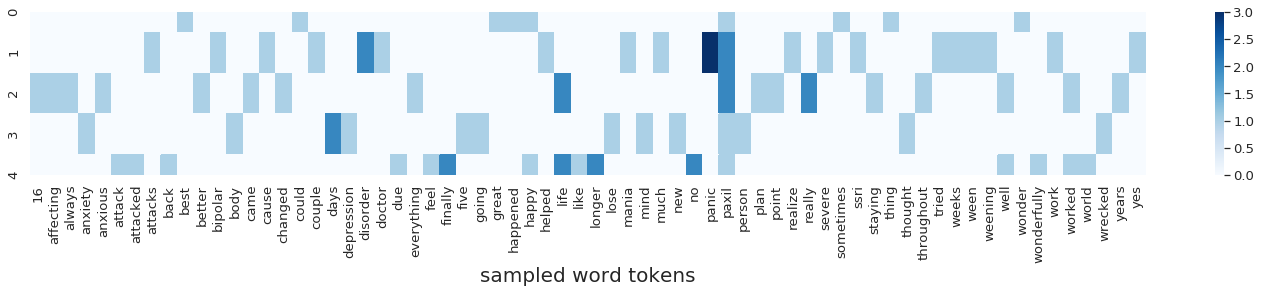

In [7]:
pretty_print(corpus)

stop_words = list(set(stopwords.words("english")) - {"no", "not", "never"})

# vect = CountVectorizer()
vect = CountVectorizer(stop_words=stop_words, lowercase=True)
# vect = CountVectorizer(ngram_range=(1, 2))
X = vect.fit_transform(corpus)
pretty_print(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))

plt.figure(figsize=(25, 3))
sns.set(font_scale=1.2)
sns.heatmap(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()), cmap="Blues")
plt.xlabel('sampled word tokens', fontsize=20)

,review
83357,Paxil is the best thing that has happened to me. Sometimes I wonder if I could be too happy. It is great!
83348,"I didn't realize how much Paxil helped with my panic disorder until my doctor tried to ween me off of it (I am bipolar, and SSRI's can cause mania), but now after a couple weeks of weening, I am having severe panic attacks. So yes, Paxil does work for panic disorder."
83080,I have been on Paxil for 16 years now. I have always been really anxious throughout my life and it came to the point where it was affecting everything I did. Paxil has changed my life for the better and has really worked well for me. I plan on staying on it.
83071,My body was wrecked with anxiety and depression. I thought I was going to lose my mind .Five days days on Paxil and I am a new person
83060,"Paxil has worked wonderfully for me. I now have a life due to it. I no longer feel like I am being attacked by the world, so I no longer attack back. I finally have a life and I am finally happy with myself as well."


,16,affecting,always,anxiety,anxious,attack,attacked,attacks,back,best,better,bipolar,body,came,cause,changed,could,couple,days,depression,disorder,doctor,due,everything,feel,finally,five,going,great,happened,happy,helped,life,like,longer,lose,mania,mind,much,new,no,panic,paxil,person,plan,point,realize,really,severe,sometimes,ssri,staying,thing,thought,throughout,tried,weeks,ween,weening,well,wonder,wonderfully,work,worked,world,wrecked,years,yes
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356281,0.356281,0.287445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356281,0.000000,0.000000,0.356281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179872,0.000000,0.000000,0.000000,0.179872,0.000000,0.000000,0.179872,0.000000,0.000000,0.179872,0.000000,0.000000,0.359743,0.179872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179872,0.000000,0.000000,0.000000,0.000000,0.179872,0.000000,0.179872,0.000000,0.000000,0.539615,0.171420,0.000000,0.000000,0.000000,0.179872,0.000000,0.179872,0.000000,0.179872,0.000000,0.000000,0.000000,0.000000,0.179872,0.179872,0.179872,0.179872,0.000000,0.000000,0.000000,0.179872,0.000000,0.000000,0.000000,0.000000,0.179872
2,0.214109,0.214109,0.214109,0.000000,0.214109,0.000000,0.000000,0.000000,0.000000,0.000000,0.214109,0.000000,0.000000,0.214109,0.000000,0.214109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204048,0.000000,0.214109,0.214109,0.000000,0.428218,0.000000,0.000000,0.000000,0.214109,0.000000,0.000000,0.214109,0.000000,0.000000,0.000000,0.000000,0.172742,0.000000,0.000000,0.000000,0.172742,0.000000,0.000000,0.214109,0.000000
3,0.000000,0.000000,0.000000,0.256267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256267,0.000000,0.000000,0.000000,0.000000,0.000000,0.512533,0.256267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256267,0.256267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256267,0.000000,0.256267,0.000000,0.256267,0.000000,0.000000,0.122112,0.256267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256267,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.200872,0.200872,0.000000,0.200872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200872,0.000000,0.200872,0.401744,0.000000,0.000000,0.000000,0.000000,0.162062,0.000000,0.324124,0.200872,0.401744,0.000000,0.000000,0.000000,0.000000,0.000000,0.401744,0.000000,0.095716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162062,0.000000,0.200872,0.000000,0.162062,0.200872,0.000000,0.000000,0.000000


Text(0.5, 0.5, 'sampled word tokens')

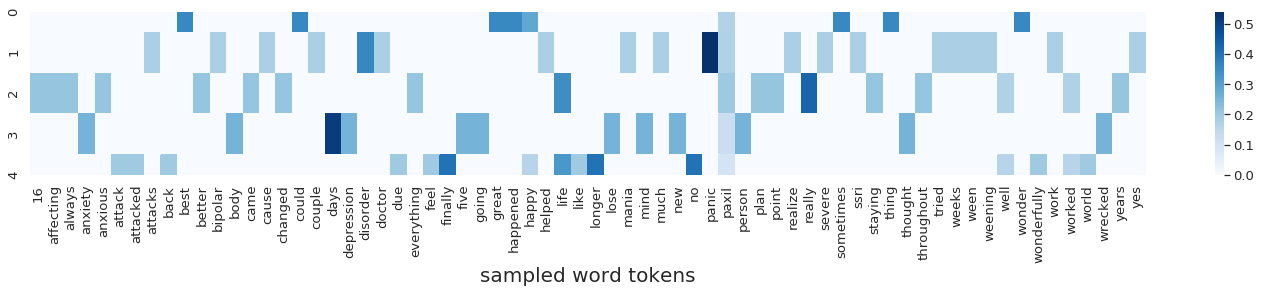

In [8]:
pretty_print(corpus)

stop_words = list(set(stopwords.words("english")) - {"no", "not", "never"})

vect = TfidfVectorizer(stop_words=stop_words, lowercase=True)
X = vect.fit_transform(corpus)
pretty_print(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))

plt.figure(figsize=(25, 3))
sns.set(font_scale=1.2)
sns.heatmap(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()), cmap="Blues")
plt.xlabel('sampled word tokens', fontsize=20)

**Step 4: modelling**

In [0]:
stop_words = list(set(stopwords.words("english")) - {"no", "not", "never"})
ngrams = 1
vect = CountVectorizer(
    min_df=4, max_features=5000, ngram_range=(1, ngrams), stop_words=stop_words, lowercase=True)
# vect = TfidfVectorizer(
#     min_df=4, max_features=5000, ngram_range=(1, ngrams), stop_words=stop_words, lowercase=True)

## Convert X_train and X_text to vectors
vect = vect.fit(X_train.append(X_test))
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


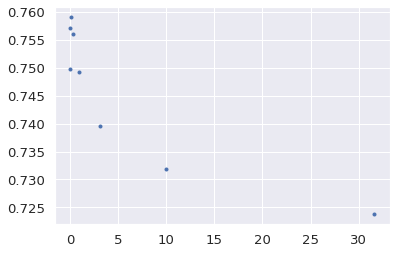

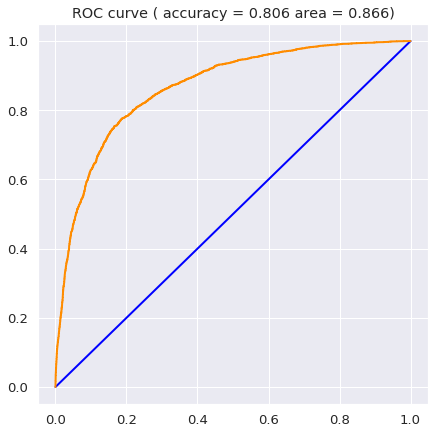

In [10]:
def train_logistic_classifier(X_train_vectorized, X_test_vectorized, y_train, y_test, threshold=0.5):
    ## Grid serach for the best hyper-parameter for Logistic Regression
    gs = GridSearchCV(estimator=LogisticRegression(),
                      param_grid={'C': 10 ** np.arange(-2, 2, 0.5)},
                      scoring='accuracy')  # scoring='roc_auc', scoring='f1'
    gs.fit(X_train_vectorized, y_train)
    plt.plot(gs.cv_results_['param_C'].data, gs.cv_results_["mean_test_score"], '.')
    plt.show()

    ## Train the model using the best hyper-parameter
    model = LogisticRegression(C=gs.best_estimator_.C)

    from sklearn.metrics import roc_curve
    ## Training set evaluation
    model = model.fit(X_train_vectorized, y_train)

    ## Test set evaluation
    y_test_pred_prob = model.predict_proba(X_test_vectorized)
    y_test_pred = model.predict_proba(X_test_vectorized)[:, 1] > threshold

    fpr, tpr, threshold = roc_curve(y_test, y_test_pred_prob[:, 1], pos_label=1)
    plt.figure(figsize=(7, 7))
    plt.plot(np.array([0, 1]), np.array([0, 1]), color='blue', linewidth=2)
    plt.plot(fpr, tpr, color='darkorange', linewidth=2)
    plt.title("ROC curve ( accuracy = " + "{0:.3f}".format(accuracy_score(y_test, y_test_pred))
              + " area = " + "{0:.3f}".format(roc_auc_score(y_test, y_test_pred_prob[:, 1])) + ")")
    plt.show()
    return model

model = train_logistic_classifier(X_train_vectorized, X_test_vectorized, y_train, y_test)

In [11]:
x = pd.Series(["This is a great drug!",
               "I don't like this drug.",
               "I do not recommend this drug."])
y = pd.Series(model.predict(vect.transform(x)))
pretty_print(pd.concat([x, y], axis=1).replace({0.0: "good", 1.0: "bad"}))

,0,1
0,This is a great drug!,good
1,I don't like this drug.,bad
2,I do not recommend this drug.,good
